Imports.

In [1]:
source("minimalESN.R") # local das funções de ESN
library(tidyverse)
set.seed(0)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.1     ✔ purrr   0.3.4
✔ tibble  3.0.1     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



Importando os dados.

In [2]:
data <- as.matrix(read.table('data/MackeyGlass_t17.txt'))

Gerando um dataset de treino e um de teste.

In [3]:
data_train <- data[1:2000]
data_test  <- data[2001:3000]

# ESN

Criando uma ESN com reservatório de 500 neurônios com esparcidade de 6%. Treinando a ESN com o conjunto de treino e realizando a previsão dos próximos 1000 pontos.

In [4]:
preds <- ESN(in.size = 1, 
             out.size = 1,
             res.size = 500,
             leaking.rate = 0.4,
             sparsity = 0.9,
             spectral.radius = 1.2,
             reg = 1e-8) %>%
  train_esn(data_train) %>%
  predict_esn(1000)

Vizualizando previsto x esperado.

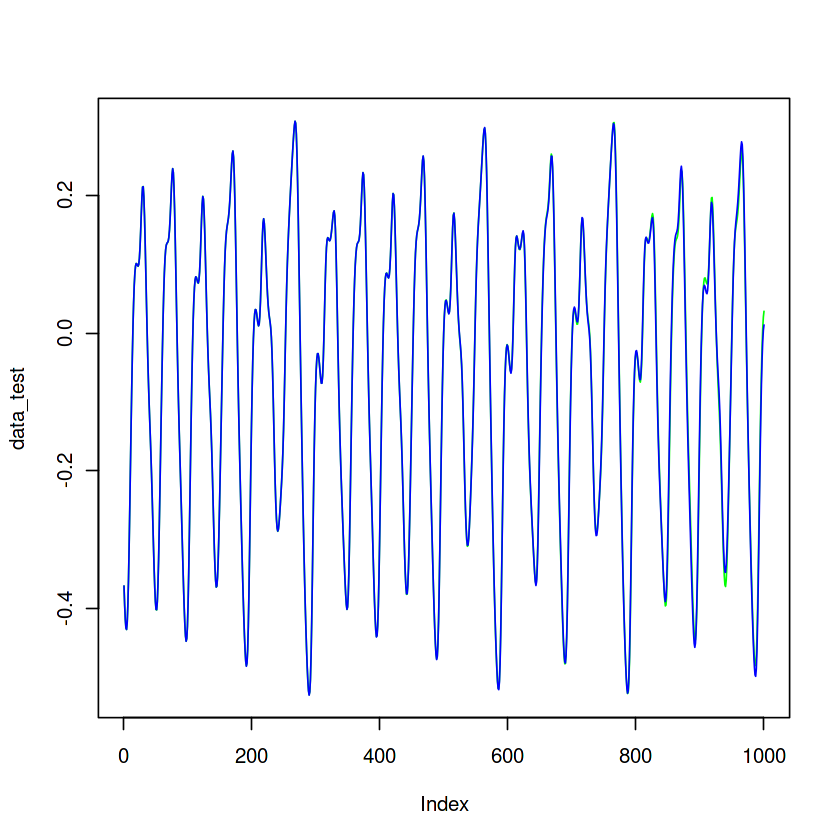

In [5]:
plot(data_test, type='l', col='green' )
lines(preds, col='blue' )

Calculando RMSE, MAE e MAPE.

In [6]:
RMSE <- sqrt(sum((data_test-preds)^2)/length(preds))
MAE <- sum(abs(data_test-preds))/length(preds)
MAPE <- sum(abs((data_test-preds)/data_test))/length(preds)
cat("RMSE: ", RMSE, "\nMAE: ", MAE, "\nMAPE: ", MAPE)

RMSE:  0.006639528 
MAE:  0.003690354 
MAPE:  0.06500682

# Funções para cross-validation

In [7]:
pred_func <- function(data, steps){
    
    preds <- ESN(in.size = 1, 
             out.size = 1,
             res.size = 500,
             leaking.rate = 0.6,
             sparsity = 0.6,
             spectral.radius = 0.8,
             reg = 0.001) %>%
      train_esn(data) %>%
      predict_esn(steps) 
    
    return(preds)
}

cross_val_ts <- function(pred_func, data, steps){
    
    errors  <- c()
    
    for(i in (steps*2):(length(data)-steps)){
        train <- data[1:i]
        test <- data[i:(i+steps-1)]
        preds <- pred_func(train, steps)
        MAE <- sum(abs(test-preds))/length(preds)
        errors <- c(errors, MAE)
    }
    
    return(errors)
}

# COVID-19

In [8]:
data <- as.vector(read.csv('data/covid_br.csv')$deaths)

In [9]:
library(forecast)
data <- data %>%
    ts(frequency=7) %>%
    stl(s.window=7, t.window=21)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



In [10]:
data <- as.matrix(data[[1]][, 1])

In [11]:
data_train <- data[1:(length(data)-14)]
data_test  <- data[(length(data)-13):(length(data))]

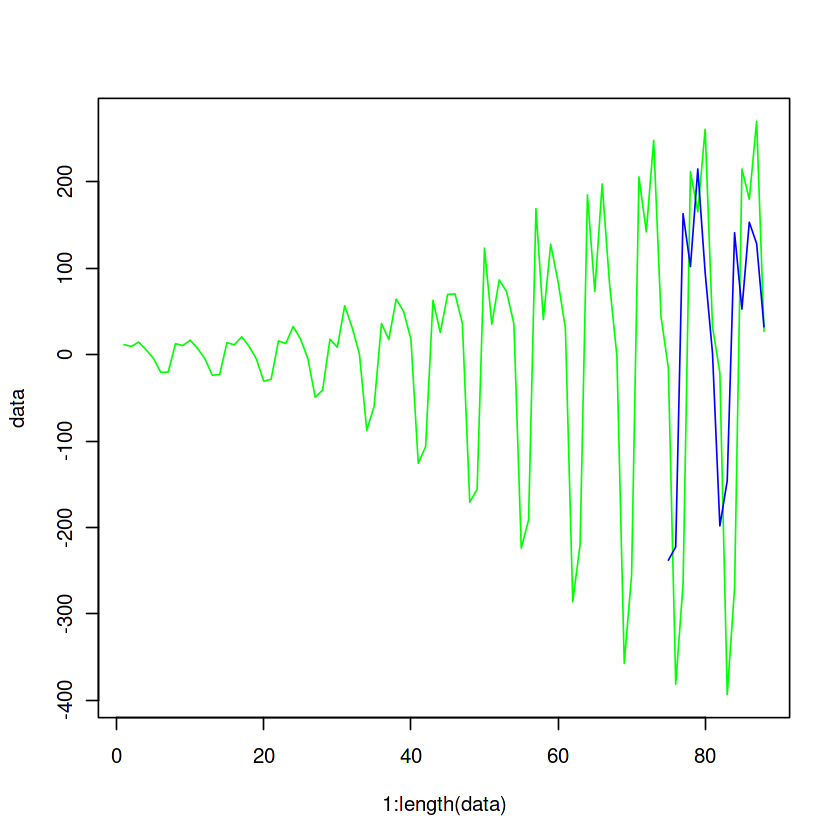

In [12]:
preds <- ESN(in.size = 1, 
             out.size = 1,
             res.size = 500,
             leaking.rate = 0.6,
             sparsity = 0.6,
             spectral.radius = 0.8,
             reg = 0.001) %>%
      train_esn(data_train) %>%
      predict_esn(14)

plot(1:length(data), data, type='l', col='green' )
lines((length(data)-13):length(data), preds, col='blue' )

In [13]:
maes <- cross_val_ts(pred_func, data, 14)

In [14]:
mean(maes)

[1] 138.4116